<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Supernova Analysis - Physics Data Science Workshop</h1>

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Section Links</h1>
<a class="list-group-item list-group-item-action" data-toggle="list" href = "#1" role="tab" aria-controls="settings">Plotting Data and Theoretical Curves<span class="badge badge-primary badge-pill">1</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">Bayesian Parameter Estimation<span class="badge badge-primary badge-pill">2</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">Markov Chain Monte Carlo Algo<span class="badge badge-primary badge-pill">3</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">MCMC metropolis algorithm<span class="badge badge-primary badge-pill">4</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">Gelman-Rubin Convergence Test<span class="badge badge-primary badge-pill">5</span></a>

<a class="list-group-item list-group-item-action" data-toggle="list" href = "#2" role="tab" aria-controls="settings">Hamiltonian Monte Carlo Algorithm<span class="badge badge-primary badge-pill">6</span></a>



In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## load data and plot theory curves

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Plotting Data and Theoretical Curves</h1><a id = "1" ></a>


load redshift, z, and distance modulus, mu, supernova data .txt file 
and use to populate dataframe

In [28]:
def load_supernova_data(file_path):
    try:
        data = pd.read_csv(file_path, sep='\s+', names=["redshift", "distance modulus"])
        return data
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None

# load in test    
supernova_df=load_supernova_data("supernova_data_file_jla_mub.txt")
supernova_df.head()

,redshift,distance modulus
0,0.010,32.953887
1,0.012,33.879003
2,0.014,33.842141
3,0.016,34.118567
4,0.019,34.593446


define functions for theoretical predictions (see project file SN-MCMC-project-2021.pdf)

In [29]:
# eta function
def eta(a, omega_m):
    s = ((1 - omega_m) / omega_m) ** (1.0 / 3)
    return 2 * omega_m ** (-0.5) * (1 / (a ** 4) - 0.1540 * s / (a ** 3)
                                    + 0.4304 * s ** 2 / (a ** 2)
                                    + 0.19097 * s ** 3 / a
                                    + 0.066941 * s ** 4) ** (-1.0 / 8)

# function to calculate distance modulus
def dist_mod_func(redshift, omega_m, hubble_const):
    DL = 3000 * (1 + redshift) * (eta(1, omega_m) - eta(1 / (1 + redshift), omega_m))
    return 25 - 5 * math.log10(hubble_const) + 5 * math.log10(DL)

plot theoretical curves, able to choose different matter densities or hubble constants. plot also data

In [30]:
# function to generate theoretical curves
def supernova_data(omega_m_values, hubble_values):
    zs = np.linspace(0.01, 2, 100)  # redshift range
    theoretical_curves = {
        f"omega_m={omega_m}, h = {h}": [dist_mod_func(z, omega_m, h) for z in zs]
        for omega_m in omega_m_values for h in hubble_values
    }

    return pd.DataFrame({'redshift': zs, **theoretical_curves})

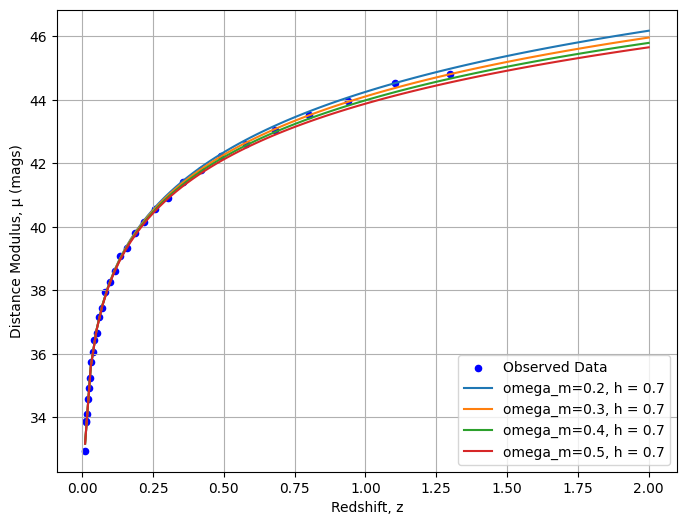

In [31]:
# plot data along with theoretical predictions
hubble_vals = [0.7]
omega_m_vals = [0.2, 0.3, 0.4, 0.5]
theoretical_df=supernova_data(omega_m_vals, hubble_vals)

fig, ax = plt.subplots(figsize=(8, 6))
    
# scatterplt of actual supernova data
supernova_df.plot(kind="scatter", x="redshift", y="distance modulus", ax=ax, label="Observed Data", color="blue")
    
# theoretical curves
for col in theoretical_df.columns[1:]:
        ax.plot(theoretical_df["redshift"], theoretical_df[col], label=col)

ax.set_xlabel('Redshift, z')
ax.set_ylabel('Distance Modulus, μ (mags)')
ax.grid(True)
ax.legend()
plt.show()

Simulate a sample of supernova.

In [32]:
def simulate_normalerror_supernova(min_redshift, max_redshift, sample_size, omega_m_vals, hubble_vals, mean, rms):
    zs_random=np.random.uniform(min_redshift, max_redshift, size=sample_size)

    simulated_data = {
        f"omega_m={omega_m}, h={h}": [dist_mod_func(z, omega_m, h)+np.random.normal(mean, rms) for z in zs_random]
        for omega_m in omega_m_vals for h in hubble_vals
    }

    return pd.DataFrame({'redshift': zs_random, **simulated_data})

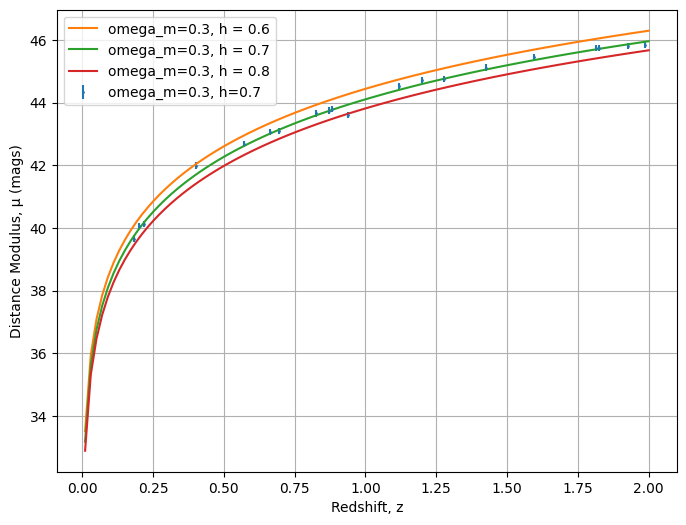

In [33]:
# plot simulated data with theoretical predictions
omega_m_vals=[0.3]
hubble_vals=[0.7]
rmserror = 0.1
simulated_df = simulate_normalerror_supernova(0, 2, 20, omega_m_vals, hubble_vals, 0, rmserror)

hubble_vals = [0.6, 0.7, 0.8]
omega_m_vals = [0.3]
theoretical_df=supernova_data(omega_m_vals, hubble_vals)


fig, ax = plt.subplots(figsize=(8, 6))
    
# scatterplt of actual supernova data
# supernova_df.plot(kind="scatter", x="redshift", y="distance modulus", ax=ax, label="Observed Data", color="blue")
    
# plot simulated data
for col in simulated_df.columns[1:]:
    ax.errorbar(simulated_df["redshift"], simulated_df[col], yerr=rmserror, fmt='o', markersize=1, label=col)

# plot theoretical curves
for col in theoretical_df.columns[1:]:
        ax.plot(theoretical_df["redshift"], theoretical_df[col], label=col)

ax.set_xlabel('Redshift, z')
ax.set_ylabel('Distance Modulus, μ (mags)')
ax.grid(True)
ax.legend()
plt.show()

## Bayesian Parameter Estimation: GENERAL METHOD

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Bayesian Parameter Estimation</h1><a id = "2" ></a>


Recipe: 
1. what is the dataset, X? aka sampled random variables
2. what is the theoretical model and what are the parameters, w, we wish to estimate?
3. prior for these parameters? p(w)
4. make probabilistic model for measured data and compute likelihood L(w, X) = p(X | w)
5. compute (un)normalised posterior p(w | X) ~ L(w, X) p(w)
6. marginalise over intermediate/nuisance parameters
7. summarise/sampling
8. check validity of priors and model

This example:
1. The data is the supernova dataset, the distance mod and redshifts pairs for each supernova. 
2. The target parameters are the omega value and hubble constant. We assume flat space so only one omega value.
3. model is the method of sampling for the x values i.e. the redshifts and then the method of generating the y values i.e. theoretical curves for modulus + noise! The noise is assume to be normally dist.
4. the nuisance parameters are the parameters for the redshift distrubution and the parameters for the noise of the modulus values. Rather than marginalising over all of these we will *condition* on the redshift values contained in the data. That is we are interested in the relationship between x and y, so the x values are included in the prior! We will marginalise over variance of the noise the mean is set to 0 (no bias, assuming additional bias would be testing a different theoretical curve! RETURN TO THIS IN VALIDATION). 
5. compute (log)likelihood and (log)posterior, check normalisation
6. marginalise over variance of noise (or leave this in and sample in a larger space)
7. sample (various methods)and summarise
8. check validity of theoretical curves model and also normally dist. noise and priors (i.e. is redshift values even representative of redshift distribution, assumptions about ). also validities of sampling 

Firstly the data is 31 data points which represent 31 bins of supernovae. The total dataset is 700 data points. There is a 31 x 31 covariance matrix describing the within bin variances and the between bin correlations.

By binning the data, this covariance data can be used to model the noise about the theoretical curves assuming gaussian noise.

In [34]:
def load_cov_data(file_path):
    try:
        data = pd.read_csv(file_path, sep='\s+', names=["covariance"])
        return data
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None

# load in covariances 
cov_df=load_cov_data("jla_mub_covmatrix.txt")
cov_df.head()
cov_df.shape

(961, 1)

### log likelihood and posterior

We now compute the log likelihood given by a gaussian (accounting for noise) about the mean value given by the theoretical curve. The log likelihood is given by the chi squared. i.e. the square of the distances of the observed data ffrom th ethoeretical value. weighted by the covariance matrix which measures the noise about the average binned the data.

define log likelihood of mu data given theoretical curve and some choice of parameters

In [35]:
def log_likelihood(mu_data, mu_theory, cov_data):
    cov_matrix=np.array(cov_data).reshape((len(mu_data), len(mu_data)))
    diff = mu_data - mu_theory
    return -0.5 * np.dot(np.dot(diff, np.linalg.inv(cov_matrix)), diff)

# example theoretical curve and log likelihood for the data given this curve
mu_theory=[dist_mod_func(z, 0.3, 0.7) for z in supernova_df["redshift"]]
log_likelihood(supernova_df["distance modulus"], mu_theory, cov_df["covariance"])

-16.999878841718306

Given the likelihood, the posterior is given by multiplying also by the prior and full probability of evidence/data. We assume uniform priors for the parameters h and omega_m  on the range 0 to 1 so the prior is just multiplying by 1. The evidence drops out of our algorithm since we are interested in ratios of probailities or (differences of log probabilities). 

This is important since we have no easy way to access the probabiliy of the evidence/data (agnostic to the parameters and/or any model) (we could compute this probability of the evidence by marginalising the likelihood over the parameter space but this is not needed) So we can just use the likelihood as the unnormalised posterior. Normalise at the end. For the log posterior normalising means ensuring it is less than 0.

## MCMC Metropolis-Hastings sampling algorithm

<h1  style="text-align: center" class="list-group-item list-group-item-action active">MCMC metropolis algorithm</h1><a id = "4" ></a>


Define code that carries out the metropolis algorithm for MCMC Monte Carlo Markov Chain method for sampling this posterior/likelihood. This algorithm works by taking a random walk in parameter space which is weighted by the posterior distribution and so samples this distribution.

first choose a distribution for way two new parameters are choosen step wise. We will use a zero mean 2D normal distribution with no correlations but variances chosen to match the posterior landscape. These variances set the step sizes of the walk. Number of steps is n_steps

In [36]:
def metropolis_hastings(mu_data, z_data, cov_data, omega_m_init, h_init, n_steps, omega_m_step_size, h_step_size, hubble_log_prior, omega_m_log_prior):
    omega_m = omega_m_init
    h = h_init 
    mu_theory = [dist_mod_func(z, omega_m, h) for z in z_data]
    log_like = log_likelihood(mu_data, mu_theory, cov_data)+hubble_log_prior(h)+omega_m_log_prior(omega_m)
    omega_m_chain = [omega_m]
    h_chain = [h]
    log_like_chain = [log_like]
    accepted = 0

    for i in range(n_steps):
        omega_m_new = omega_m + np.random.normal(0, omega_m_step_size)
        h_new = h + np.random.normal(0, h_step_size)
        mu_theory = [dist_mod_func(z, omega_m_new, h_new) for z in z_data]
        log_like_new = log_likelihood(mu_data, mu_theory, cov_data)+hubble_log_prior(h_new)+omega_m_log_prior(omega_m_new)
        if log_like_new - log_like > 0:
            omega_m = omega_m_new
            h = h_new
            log_like = log_like_new
            accepted += 1
        elif np.log(np.random.rand()) < log_like_new - log_like:
            omega_m = omega_m_new
            h = h_new
            log_like = log_like_new
            accepted += 1

        omega_m_chain.append(omega_m)
        h_chain.append(h)
        log_like_chain.append(log_like)

    return pd.DataFrame({"omega_m":omega_m_chain, "hubble const":h_chain, "log post":log_like_chain}), accepted/n_steps

we will use flat priors on [0,1]

In [37]:
def logflatprior(x):
    return 0

Build dataframe with chains and the paramters and log likelihood

In [38]:
samples=metropolis_hastings(supernova_df["distance modulus"], supernova_df["redshift"], cov_df["covariance"], 0.5, 0.5, 10000, 0.01, 0.01, logflatprior, logflatprior)
sample_df=samples[0]
print(accepted_prob:=samples[1])
sample_df.head()

0.5083


,omega_m,hubble const,log post
0,0.500000,0.500000,-731.977788
1,0.500000,0.500000,-731.977788
2,0.500000,0.500000,-731.977788
3,0.503201,0.504718,-686.358762
4,0.515082,0.508179,-647.218862


Accepted probability i.e. chance to make a step in the walk is between 0.1 and 0.5 which is okay.

scatter plot the markov chain samples and their log likelihoods

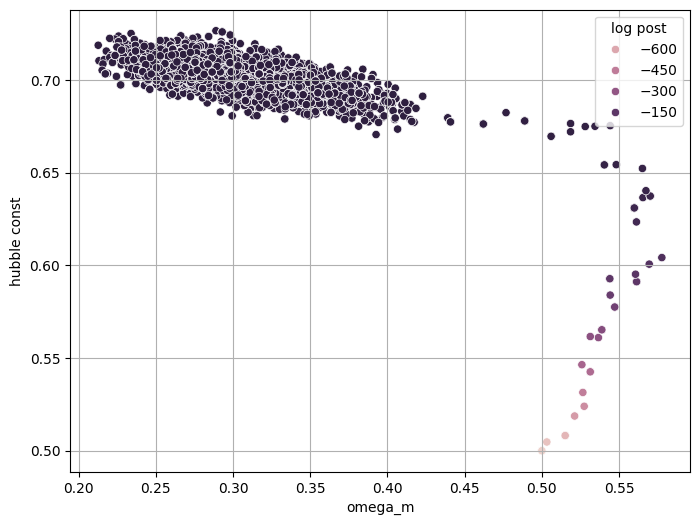

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.scatterplot(sample_df, x="omega_m", y="hubble const", hue="log post")

ax.set_xlabel('omega_m')
ax.set_ylabel('hubble const')
ax.grid(True)
plt.show()

We see a 'burn in' due to our initial conditions. The random walk takes a few steps before converging towards and exploring the regions of high probability density. We can see this again using trace plot of the evolution of the random walk in parameter space.

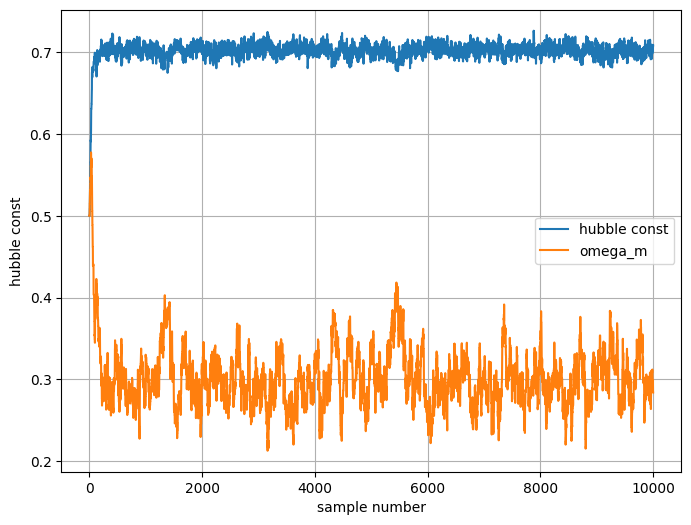

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.lineplot(sample_df, x=sample_df.index, y="hubble const", ax=ax, label="hubble const")
sns.lineplot(sample_df,x =sample_df.index, y="omega_m", ax=ax, label="omega_m")

ax.grid(True)
ax.set_xlabel('sample number')
ax.legend()
plt.show()

## Summary Statistics

We truncate data to drop the burn in initial phase

In [41]:
sample_trunc_df=sample_df.copy()
sample_trunc_df=sample_trunc_df[1000:]

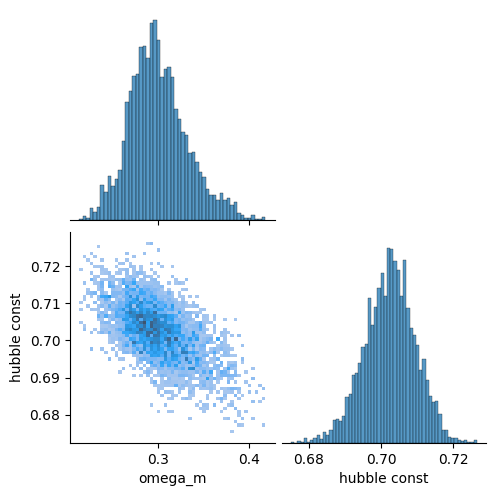

In [42]:
sns.pairplot(sample_trunc_df, vars=["omega_m","hubble const"], corner=True, kind="hist")
plt.show()

mean and median and covariances

In [43]:
print(sample_trunc_df.drop(['log post'], axis = 1).mean())
print(sample_trunc_df.drop(['log post'], axis = 1).median())
print(sample_trunc_df.drop(['log post'], axis = 1).cov())

omega_m         0.300153
hubble const    0.702400
dtype: float64
omega_m         0.296975
hubble const    0.702632
dtype: float64
               omega_m  hubble const
omega_m       0.001050     -0.000141
hubble const -0.000141      0.000050


mode

In [44]:
sample_trunc_df.sort_values(by="log post", ascending=False, inplace=True)
sample_trunc_df.iloc[0]

omega_m          0.293895
hubble const     0.703202
log post       -16.894683
Name: 8388, dtype: float64

Correlation Length

In [45]:
corr_df = sample_df.copy()
corr_df.drop("log post", axis=1, inplace=True)
for col in corr_df.columns:
    corr_df[col] = [corr_df[col].autocorr(lag) for lag in range(len(corr_df))]
corr_df.drop(range(5000, 9999), axis=0, inplace=True)

/Users/joshgowdy/.pyenv/versions/3.10.14/envs/datasci_edu_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/joshgowdy/.pyenv/versions/3.10.14/envs/datasci_edu_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


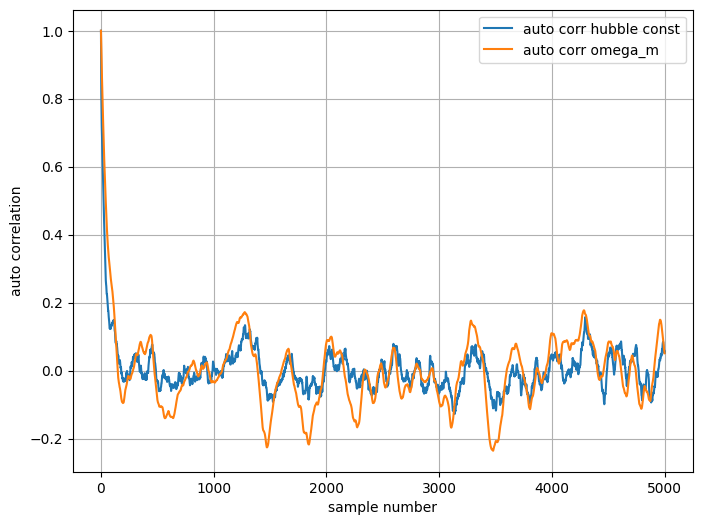

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.lineplot(corr_df, x=corr_df.index, y="hubble const", ax=ax, label="auto corr hubble const")
sns.lineplot(corr_df,x =corr_df.index, y="omega_m", ax=ax, label="auto corr omega_m")

ax.grid(True)
ax.set_xlabel('sample number')
ax.set_ylabel('auto correlation')
ax.legend()
plt.show()

## Try a Different Prior

try a different prior for the Hubble constant. We try a prior which is gaussian with mean 0.738 and st dev 0.024. This means that the posterior is no longer simply given by the likelihood on the range [0,1] (flat prior). We can however get the new posterior by weighting the samples by this new prior (this is an example of *importance sampling*). 

In [47]:
def gauss_exponent(mean, stdev):
    return lambda x: -0.5 * ((x - mean) / stdev) ** 2

In [48]:
h_prior_m=0.2
h_prior_stdev=0.01
gauss_logprior=gauss_exponent(h_prior_m, h_prior_stdev)
samples_gauss=metropolis_hastings(supernova_df["distance modulus"], supernova_df["redshift"], cov_df["covariance"], 0.5, 0.5, 10000, 0.01, 0.01, gauss_logprior, logflatprior)
sample_gauss_df=samples_gauss[0]
print(accepted_prob:=samples_gauss[1])
sample_gauss_df.head()

0.4042


,omega_m,hubble const,log post
0,0.500000,0.500000,-1181.977788
1,0.490000,0.500970,-1183.780157
2,0.501395,0.505756,-1145.897372
3,0.509264,0.524249,-1047.969653
4,0.515023,0.535226,-1003.336229


In [49]:
h_prior_m=0.738
h_prior_stdev=0.024
gauss_prior=gauss_exponent(h_prior_m, h_prior_stdev)
samples_goodgauss=metropolis_hastings(supernova_df["distance modulus"], supernova_df["redshift"], cov_df["covariance"], 0.5, 0.5, 10000, 0.01, 0.01, gauss_prior, logflatprior)
sample_goodgauss_df=samples_goodgauss[0]
print(accepted_prob:=samples_goodgauss[1])
sample_goodgauss_df.head()

0.5074


,omega_m,hubble const,log post
0,0.500000,0.500000,-781.147927
1,0.489925,0.513080,-667.666047
2,0.489925,0.513080,-667.666047
3,0.477694,0.514645,-662.888558
4,0.477694,0.514645,-662.888558


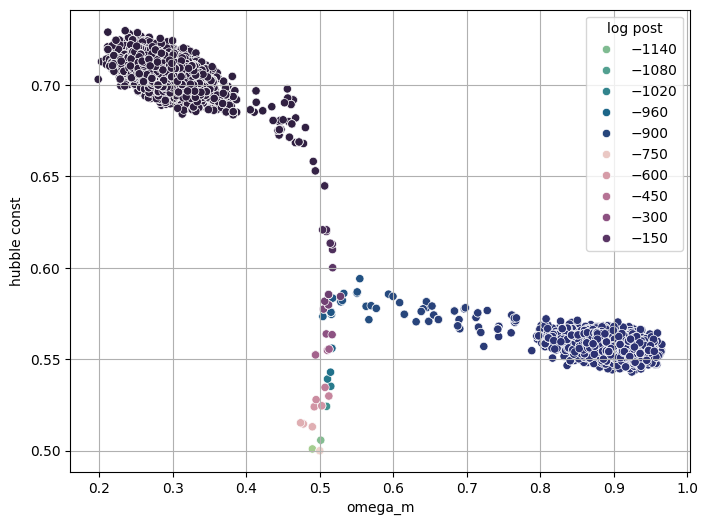

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.scatterplot(sample_gauss_df, x="omega_m", y="hubble const", hue="log post", palette="crest")
sns.scatterplot(sample_goodgauss_df, x="omega_m", y="hubble const", hue="log post")

ax.set_xlabel('omega_m')
ax.set_ylabel('hubble const')
ax.grid(True)
plt.show()

With the prior peaked narrowly at a wrong value for hubble constant we see that the burn in is longer as the prior influences the posterior. However the data is informative and prevails in the end. There is lasting bias however, the settle value for the estimate for the paramters is different to before.

## Convergence Testing

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Gelman-Rubin Convergence Test</h1><a id = "5" ></a>

## Hamiltonian Monte Carlo

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Hamiltonian Monte Carlo</h1><a id = "6" ></a>

We define a Hamiltonian Monte Carlo Algorithm to sample the posterior distribution in a more efficient way.